In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.utils as vutils
import os
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Monter Google Drive pour accéder au dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration
dataset_path = "/content/drive/MyDrive/Bloc4Viken/utkcropped"

In [ ]:
image_size = 64
batch_size = 4  # Batch size réduit pour CPU
nz = 100  # Taille du vecteur latent
num_epochs = 5  # Nombre réduit d'époques pour un premier résultat
learning_rate = 0.0002
save_path = "/content/drive/MyDrive/Bloc4Viken/dcgan_checkpoint.pth"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Définir une classe pour le dataset UTKFace Cropped
class UTKFaceDataset(data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, 0  # On ne se sert pas des labels ici, donc on retourne simplement une valeur arbitraire pour le label (0)

In [ ]:
# Transformation des images (redimensionnement, conversion en tensor, normalisation)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Chargement du dataset UTKFace Cropped
dataset = UTKFaceDataset(root_dir=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Définition du Générateur
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
# Définition du Discriminateur
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialisation du GAN
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Chargement du modèle si disponible
if os.path.exists(save_path):
    checkpoint = torch.load(save_path, map_location=device)
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d'])
    print("Modèle chargé avec succès !")

In [ ]:
# Fonction pour afficher les images générées pendant l'entraînement
def show_generated_images(epoch, i, fake_images):
    # Convertir les images générées en format NumPy pour affichage
    fake_images = fake_images.detach().cpu()
    grid = vutils.make_grid(fake_images, padding=2, normalize=True)
    npimg = grid.numpy()

    # Afficher l'image dans Google Colab
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Epoch {epoch} Batch {i}")
    plt.axis('off')
    plt.show()

Epoch [0/5] Batch 0 Loss D: 1.4855434894561768, Loss G: 5.916622638702393


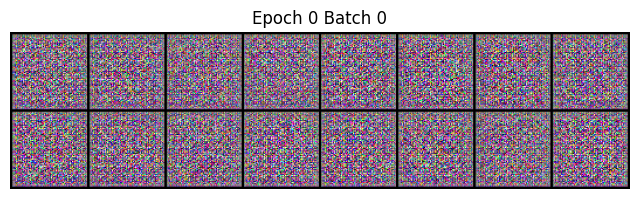

Epoch [0/5] Batch 50 Loss D: 0.7618790864944458, Loss G: 6.614123344421387


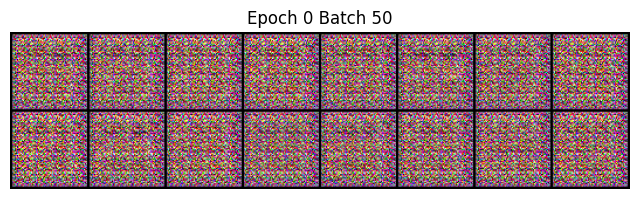

Epoch [0/5] Batch 100 Loss D: 3.0308239459991455, Loss G: 16.857418060302734


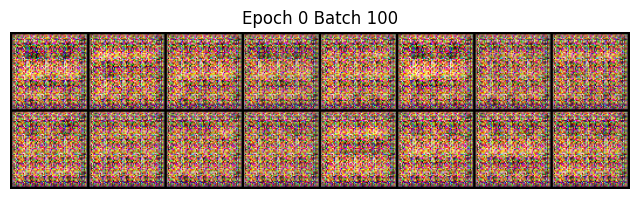

Epoch [0/5] Batch 150 Loss D: 0.7731056809425354, Loss G: 10.85281753540039


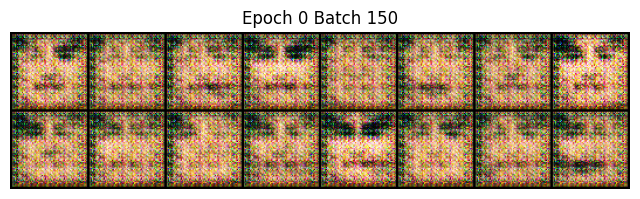

Epoch [0/5] Batch 200 Loss D: 0.07408902049064636, Loss G: 5.837252140045166


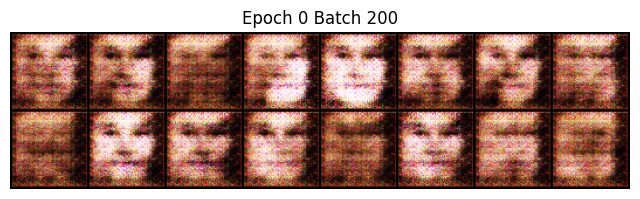

Epoch [0/5] Batch 250 Loss D: 0.09580272436141968, Loss G: 3.0417137145996094


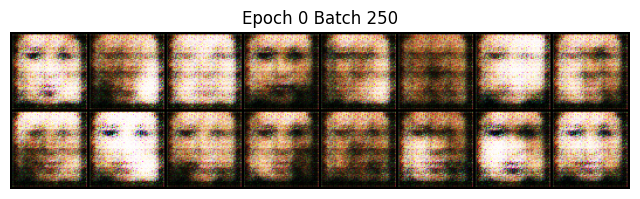

In [ ]:
# Entraînement
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        # Entraînement du Discriminateur
        optimizer_d.zero_grad()
        output_real = discriminator(real_images).view(-1, 1)
        loss_real = criterion(output_real, labels_real)

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, labels_fake)

        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Entraînement du Générateur
        optimizer_g.zero_grad()
        output_fake = discriminator(fake_images).view(-1, 1)
        loss_g = criterion(output_fake, labels_real)
        loss_g.backward()
        optimizer_g.step()

        # Affichage périodique des pertes et des images générées
        if i % 50 == 0:  # Afficher les résultats tous les 50 batches
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i} Loss D: {loss_d.item()}, Loss G: {loss_g.item()}")

            # Afficher les images générées
            with torch.no_grad():
                fake_images = generator(torch.randn(16, nz, 1, 1, device=device))
                show_generated_images(epoch, i, fake_images)

    # Sauvegarder le modèle à la fin de chaque époque
    torch.save({
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimizer_g': optimizer_g.state_dict(),
        'optimizer_d': optimizer_d.state_dict()
    }, save_path)

In [ ]:
print("Entraînement terminé !")